## Solutions for Stellar Physics Lab 1

In [1]:
## preliminaries
from astroquery.simbad import Simbad
from astroquery.ipac.irsa import Irsa
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, least_squares
from scipy.integrate import quad
%matplotlib inline

### 1) Stellar Photometry
I'm going to do this at the command line just as an example in using Python

In [2]:
### let's get a list of fields for our Simbad query, because we're going to have to add some
Simbad.list_votable_fields()

name,description,type
object,object,object
mesDiameter,Collection of stellar diameters.,table
mesPM,Collection of proper motions.,table
mesISO,Infrared Space Observatory (ISO) observing log.,table
mesSpT,Collection of spectral types.,table
allfluxes,"all flux/magnitudes U,B,V,I,J,H,K,u_,g_,r_,i_,z_",table
ident,Identifiers of an astronomical object,table
flux,Magnitude/Flux information about an astronomical object,table
...,...,...
r,Magnitude SDSS r,filter name


In [3]:
### let's add "fluxes" (these are actually magnitudes), for some of the 
### filters that we see for Spica:
### http://simbad.u-strasbg.fr/simbad/sim-id?Ident=spica&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id)
customSimbad = Simbad()
customSimbad.add_votable_fields('U','B','V','R',
                                'I','J','H','K',
                                'u','g','r','i',
                                'z')

### 1.1) Download Optical and WISE data
First Simbad, then AllWISE

In [4]:
magnitude_dict = {}
object_list = ['Betelgeuse','Alioth','Rigel','alf Cen A']
for o in object_list:
    result_table = customSimbad.query_object(o)
    magnitude_dict[o] = []
    for filt in 'UBVRIJHK':
        magnitude_dict[o] += [float(result_table[filt])]
        
    for filt in 'ugriz':
        magnitude_dict[o] += [float(result_table[filt])]
        
    result_wise = Irsa.query_region(
        o, catalog="allwise_p3as_psd", spatial="Cone", selcols="ra,dec,w1mpro,w2mpro,w3mpro,w4mpro")
    for filt,colname in zip(['WISE_W1','WISE_W2','WISE_W3','WISE_W4'],
                            ['w1mpro','w2mpro','w3mpro','w4mpro']):
        if len(result_wise):
            magnitude_dict[o] += [float(result_wise[colname][0])]
        else:
            magnitude_dict[o] += [None]
        

/var/folders/30/s1tw2tyx5tlbzkrw94k25fth0000gn/T/ipykernel_8979/1912851732.py:10: UserWarning: Warning: converting a masked element to nan.
  magnitude_dict[o] += [float(result_table[filt])]
/var/folders/30/s1tw2tyx5tlbzkrw94k25fth0000gn/T/ipykernel_8979/1912851732.py:7: UserWarning: Warning: converting a masked element to nan.
  magnitude_dict[o] += [float(result_table[filt])]


In [5]:
### let's check that it worked
### looks like we'll have to filter out some missing (NaN) values when we analyze
magnitude_dict['alf Cen A']

[0.9599999785423279,
 0.7200000286102295,
 0.009999999776482582,
 nan,
 nan,
 -1.4539999961853027,
 -1.8860000371932983,
 -2.007999897003174,
 nan,
 nan,
 nan,
 nan,
 nan,
 None,
 None,
 None,
 None]

Let's also see what the results table looks like

In [6]:
print(result_table)

  main_id           ra                dec         ...  z   u   matched_id
                   deg                deg         ...                    
----------- ------------------ ------------------ ... --- --- -----------
* alf Cen A 219.90205833170774 -60.83399268831004 ...  --  -- * alf Cen A


Add in Ka ‘onohi ali’i by hand (using the paper's johnson conversions)

In [7]:
magnitude_dict['Procyon Beta'] = [10.62,11.13,10.92,10.72,10.97,None,None,None,None,None,None,None,None,None,None,None,None]

### 2) Convert Magnitudes and Plot
This step is more difficult than it seems, especially with one main tool (Gemini) currently offline.  You can check your answers for Johnson filters (UBVRI) and 2MASS here:
https://irsa.ipac.caltech.edu/data/SPITZER/docs/dataanalysistools/tools/pet/magtojy/
For WISE, section 1 here: https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html#conv2flux will get you to Jansky units, and then you'll have to convert from there to $W/m^2/\mu m$.

First we're going to convert from Vega to AB magnitudes.  We can compute this ourselves, with some effort, but let's just use the internet: 
https://www.astronomy.ohio-state.edu/martini.10/usefuldata.html
https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html

We also need effective filter wavelengths.  I got these here (approximate #s are fine for us)
https://www.aavso.org/filters
https://www.astro.ucla.edu/~wright/WISE/passbands.html

In [8]:
### I like numpy arrays better than lists
filter_names = np.array(['U','B','V','R','I','J','H','K','u','g','r','i','z','W1','W2','W3','W4'])
vega_to_AB_conv = np.array([0.79,-0.09,0.02,0.21,0.45,0.91,1.39,1.85,0,0,0,0,0,2.699,3.339,5.174,6.620])
filter_eff_wavelengths = np.array([0.3663,0.4361,0.5448,0.6407,0.7980,1.2,1.6,2.2,0.3608,0.4671,0.6141,0.7470,0.8922,3.368, 4.618, 12.082,22.194])

Second, we're going to use astropy to get our flux densities

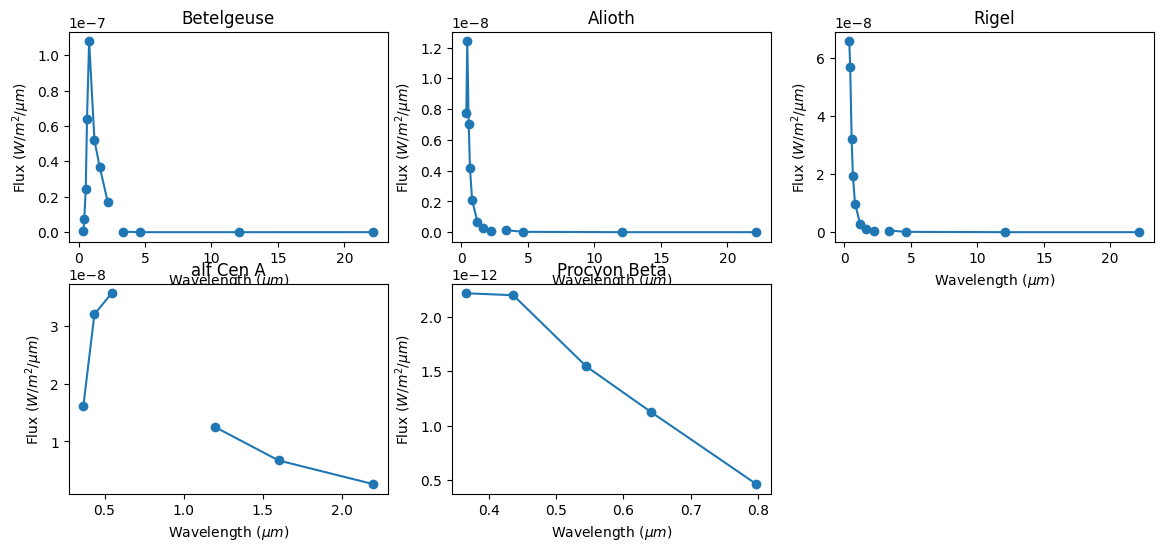

In [9]:
### now let's plot the first three
plt.rcParams['figure.figsize'] = (14,6)
ax1,ax2,ax3,ax4,ax5 = plt.subplot(231),plt.subplot(232),plt.subplot(233),plt.subplot(234),plt.subplot(235)
for star,ax in zip(['Betelgeuse','Alioth','Rigel','alf Cen A','Procyon Beta'],[ax1,ax2,ax3,ax4,ax5]):
    flux_densities = []
    for m,w,vega_AB in zip(magnitude_dict[star],filter_eff_wavelengths,vega_to_AB_conv):
        if m is not None:
            ABmag = (m + vega_AB)*u.ABmag
            lam = w*u.micron
            flam = ABmag.to(u.W/u.m**2/u.micron, u.spectral_density(lam))
            flux_densities += [flam.value]
        else:
            flux_densities += [None]
    flux_densities = np.array(flux_densities)
    iOK = np.where(flux_densities != None)[0]
    ax.plot(filter_eff_wavelengths[iOK],flux_densities[iOK],'o-')
    ax.set_title(star)
    ax.set_xlabel('Wavelength ($\mu m$)')
    ax.set_ylabel('Flux ($W/m^2/\mu m$)')

### 3) Fit Temperature

#### 3.1) Fitting SED with a Planck Function
The black body equation as a function of wavelength is as follows:

$B_{\lambda}(\lambda,T) = \frac{2hc^2}{\lambda^5} \frac{1}{e^{hc/(\lambda k_B T)} - 1}$


Let's code this up as a function

In [10]:
_h = 6.626 * 10**(-34)  ## SI units
_c = 3e8 ### m/s
_kb = 1.3807 * 10**(-23)

def b_lambda(lam,T):
    lam_m = lam * 1e-6 # micron to m
    return 2*_h*_c**2/lam_m**5/(np.exp(_h*_c/(lam_m*_kb*T)) - 1)

def b_lam_fitting(x,lam=None,flux=None):
    amplitude,T = x
    b_model = amplitude*b_lambda(lam,T)
    return (flux-b_model) #/(0.05*flux)

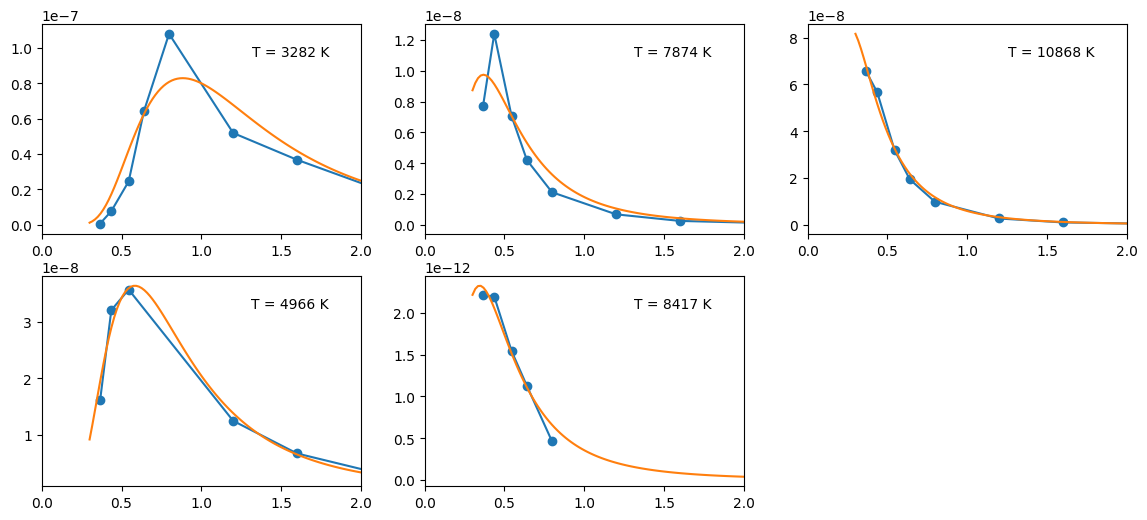

In [11]:
### iterate over the first three stars and fit the black body function
### this fitting isn't great -- we need a good initial guess for the amplitude and sometimes temperature
### so I tried some options here
plt.rcParams['figure.figsize'] = (14,6)
ax1,ax2,ax3,ax4,ax5 = plt.subplot(231),plt.subplot(232),plt.subplot(233),plt.subplot(234),plt.subplot(235)
amplitudes,temps = [],[]
for star,ax,amp_guess,temp_guess in zip(
        ['Betelgeuse','Alioth','Rigel','alf Cen A','Procyon Beta'],
        [ax1,ax2,ax3,ax4,ax5],
        [1e-20,1e-26,1e-20,1e-20,1e-20],
        [2000,9000,6000,6000,6000]):

    flux_densities = []
    wave_eff_out = []
    for m,w,vega_AB in zip(magnitude_dict[star],filter_eff_wavelengths,vega_to_AB_conv):
        if m != m or m is None: continue
        ABmag = (m + vega_AB)*u.ABmag
        lam = w*u.micron
        flam = ABmag.to(u.W/u.m**2/u.micron, u.spectral_density(lam))
        flux_densities += [flam.value]
        wave_eff_out += [w]
    flux_densities,wave_eff_out = np.array(flux_densities),np.array(wave_eff_out)
        
    result = least_squares(
        b_lam_fitting,[amp_guess,temp_guess],
        args=(wave_eff_out,flux_densities),method='lm')
    #result = minimize(
    #    b_lam_fitting_2,[amp_guess,temp_guess],
    #    args=(wave_eff_out,flux_densities))
    ax.plot(wave_eff_out,flux_densities,'o-')
    lam = np.linspace(0.3,2,100)
    ax.plot(lam,result.x[0]*b_lambda(lam,result.x[1]))
    ax.text(0.9,0.9,f'T = {result.x[1]:.0f} K',ha='right',va='top',transform=ax.transAxes)
    amplitudes += [result.x[0]]
    temps += [result.x[1]]
    ax.set_xlim([0,2])

#### 3.2.2
Spectral types for these three stars are M1 (Betelgeuse), A1 (Alioth), B8 (Rigel), G2 (alf Cen A), and Procyon B is a white dwarf.  From https://sites.uni.edu/morgans/astro/course/Notes/section2/spectraltemps.html I expect temperatures of 3700, 9330, 12,300, 5800, and 8688 (derived in the paper).  But, these stars are not perfect blackbodies and likely absorption features are biasing some of our temperature determinations.  Still, we're within ~100K for all!

### 4) Calculate the Radius of the Stars

First we need to get an estimate of the total luminosity.  We can do that by integrating the planck function, including the amplitude offset from 0 -> some large number.

In [12]:
parallaxes = np.array([6.55e-3,39.51e-3,3.78e-3,742.12e-3,0.2864]) ## from Simbad/the linked Procyon B paper, in mas converted to arcsec
# for the first 5.  a parallax is listed in Simbad but it's **totally wrong**
distances = 1/parallaxes * 3.086e16
#distances = np.append(distances,762.3e6 * 3.086e16) # this last number is using Ned Wright's cosmology calculator given the redshift
_sigma = 5.67e-8

for star,amp,t,d in zip(['Betelgeuse','Alioth','Rigel','alf Cen A','Procyon Beta'],amplitudes,temps,distances):
    blt = lambda x: b_lambda(x,t)
    flux = amp*quad(blt,0,20)[0]
    lum = 4*np.pi*d**2.*flux
    print(star)
    print(f"luminosity = {lum:8.3e} W, {lum/3.86e26:.3f} solar luminosities")
    
    radius = np.sqrt(lum/(4*np.pi*_sigma*t**4))
    print(f"radius = {radius:8.3e} m, {radius/6.96e8:.3f} solar radii")
    print("")

Betelgeuse
luminosity = 3.102e+31 W, 80362.990 solar luminosities
radius = 6.126e+11 m, 880.186 solar radii

Alioth
luminosity = 4.186e+28 W, 108.438 solar luminosities
radius = 3.909e+09 m, 5.617 solar radii

Rigel
luminosity = 2.865e+31 W, 74231.531 solar luminosities
radius = 5.369e+10 m, 77.142 solar radii

alf Cen A
luminosity = 7.013e+26 W, 1.817 solar luminosities
radius = 1.272e+09 m, 1.828 solar radii

Procyon Beta
luminosity = 1.779e+23 W, 0.000 solar luminosities
radius = 7.053e+06 m, 0.010 solar radii



/var/folders/30/s1tw2tyx5tlbzkrw94k25fth0000gn/T/ipykernel_8979/4069595991.py:7: RuntimeWarning: overflow encountered in exp
  return 2*_h*_c**2/lam_m**5/(np.exp(_h*_c/(lam_m*_kb*T)) - 1)
